# <font color =redblue> Machine Learning Approach Towards Startups Success Prediction
# <font color =redblue> Zahra Al Huraiz , Khaled Halawani, Reda Al Hamza

In [1]:
# Run this code block only for the first time. 

!pip install imblearn==0.0
!pip install dmba
!pip install xgboost


[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import statistics
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from dmba import plotDecisionTree, classificationSummary, regressionSummary
from imblearn.over_sampling import SMOTE
from collections import Counter
from array import array
from sklearn import preprocessing, svm , metrics , tree
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

# <font color = lightgreenblue> 1) Import Data & Basic Exploration

In [3]:
start_ups= pd.read_csv("Startups2.csv")
start_ups.set_index('Organization_Name', inplace=True)

In [4]:
start_ups.info()

<class 'pandas.core.frame.DataFrame'>
Index: 979 entries, Nana to Saudi Re For Cooperative Reinsurance Co.
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Estimated_Revenue_Range  394 non-null    float64
 1   Total_Funding_Amount     210 non-null    float64
 2   Headquarters_Location    979 non-null    object 
 3   Description              979 non-null    object 
 4   Founded_Date             979 non-null    int64  
 5   Number_of_Founders       330 non-null    float64
 6   Funding_Status           349 non-null    object 
 7   Funding_Stage            979 non-null    object 
 8   Number_Funding_Rounds    271 non-null    float64
 9   Number_of_Investors      224 non-null    float64
 10  Industries               962 non-null    object 
 11  Industry_Groups          979 non-null    object 
 12  Sector_Size              979 non-null    int64  
 13  Number_of_Employees      979 non-null    int6

In [5]:
# less than 20 is categorical variable
start_ups.nunique()

Estimated_Revenue_Range      7
Total_Funding_Amount       141
Headquarters_Location       16
Description                979
Founded_Date                36
Number_of_Founders           6
Funding_Status               6
Funding_Stage                9
Number_Funding_Rounds        7
Number_of_Investors         13
Industries                 839
Industry_Groups             33
Sector_Size                  7
Number_of_Employees          7
Downloads_Last_30_Days      46
Number_of_Apps              21
Visit_Duration             324
Bounce_Rate                 92
Monthly_Visits             477
Monthly_Visits_Growth      237
Exit_status                  2
dtype: int64

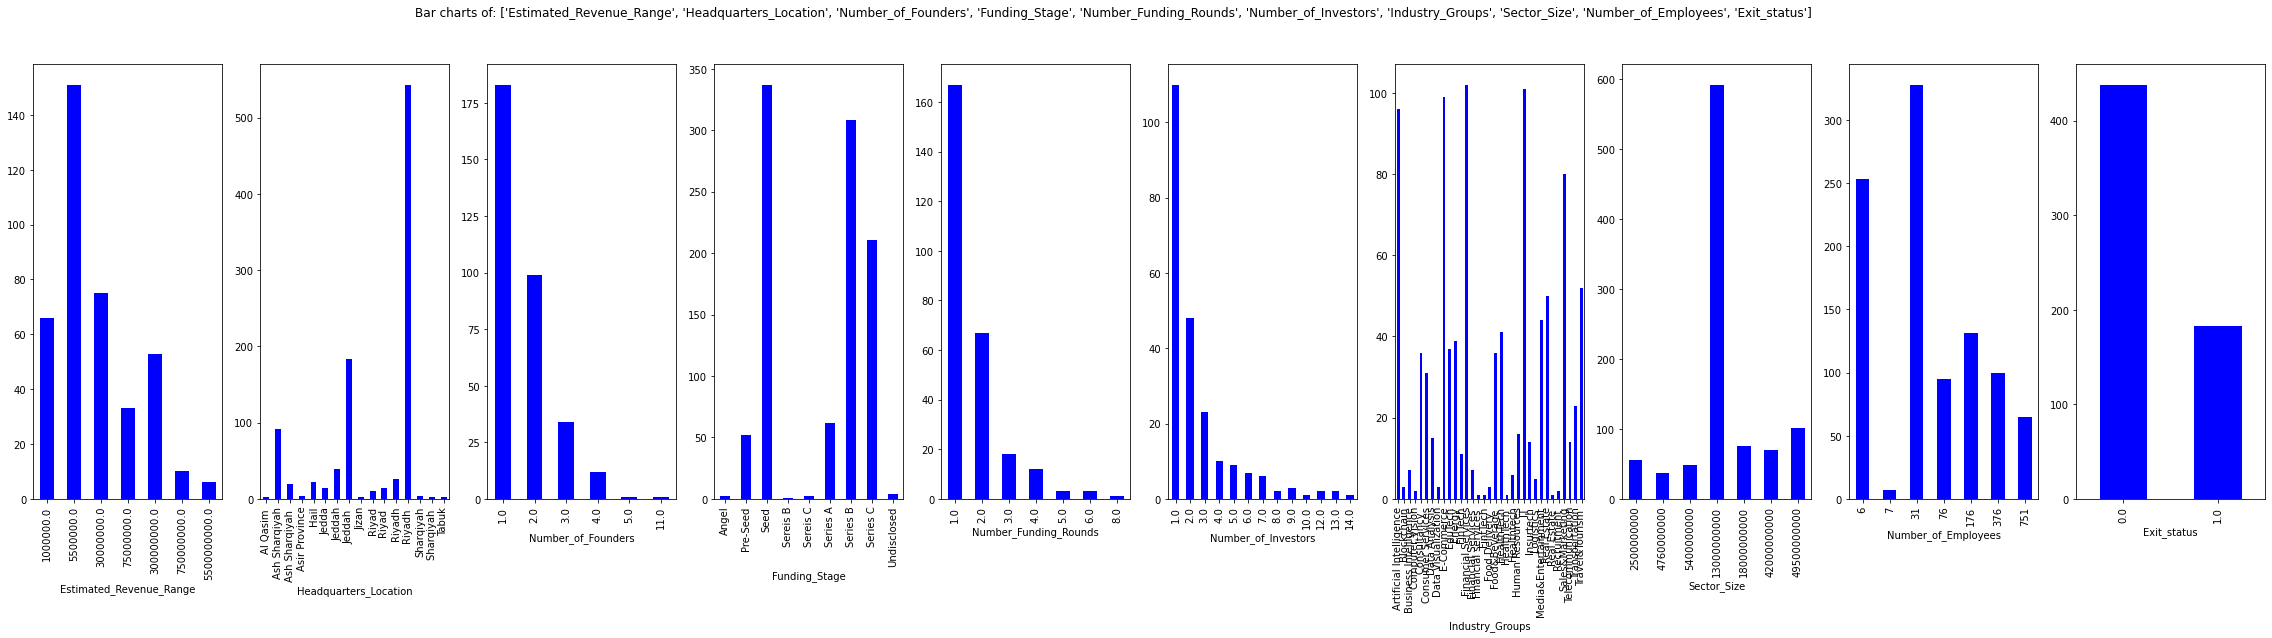

In [6]:
# Bar Chart for Categorical variable
def PlotBarCharts(inpData, colsToPlot):
   
    # Generating multiple subplots
    fig, subPlot=plt.subplots(nrows=1, ncols=len(colsToPlot), figsize=(40,8))
    fig.suptitle('Bar charts of: '+ str(colsToPlot))

    for colName, plotNumber in zip(colsToPlot, range(len(colsToPlot))):
        inpData.groupby(colName).size().plot(kind='bar',ax=subPlot[plotNumber], cmap='winter')

PlotBarCharts(inpData=start_ups, colsToPlot=["Estimated_Revenue_Range", "Headquarters_Location", "Number_of_Founders",
                                             "Funding_Stage", "Number_Funding_Rounds" , "Number_of_Investors",
                                             "Industry_Groups", "Sector_Size", "Number_of_Employees", "Exit_status"]) 

# <font color = lightgreenblue> 2) Missing Values Identification & Treatment 

## <font color =redblue> A. Identifying Missing Values

In [7]:
start_ups.isnull().sum() 

Estimated_Revenue_Range    585
Total_Funding_Amount       769
Headquarters_Location        0
Description                  0
Founded_Date                 0
Number_of_Founders         649
Funding_Status             630
Funding_Stage                0
Number_Funding_Rounds      708
Number_of_Investors        755
Industries                  17
Industry_Groups              0
Sector_Size                  0
Number_of_Employees          0
Downloads_Last_30_Days     933
Number_of_Apps             886
Visit_Duration             438
Bounce_Rate                438
Monthly_Visits             438
Monthly_Visits_Growth      549
Exit_status                358
dtype: int64

## <font color =redblue> B. Missing Values Treatment 

### Replace Missing value with suitable replacement based on the nature of the column

In [8]:
start_ups['Estimated_Revenue_Range'] = start_ups['Estimated_Revenue_Range'].replace({np.NaN :'5500000'})
start_ups['Total_Funding_Amount'] = start_ups['Total_Funding_Amount'].replace({np.NaN :'800000'})
start_ups['Number_of_Founders'] = start_ups['Number_of_Founders'].replace({np.NaN :'2'})
start_ups['Number_Funding_Rounds'] = start_ups['Number_Funding_Rounds'].replace({np.NaN :'1'})
start_ups['Number_of_Investors'] = start_ups['Number_of_Investors'].replace({np.NaN :'1'})
start_ups['Number_of_Apps'] = start_ups['Number_of_Apps'].replace({np.NaN :'1'})
start_ups['Visit_Duration'] = start_ups['Visit_Duration'].replace({np.NaN :'178'})
start_ups['Bounce_Rate'] = start_ups['Bounce_Rate'].replace({np.NaN :'66.56%'})
start_ups['Monthly_Visits'] = start_ups['Monthly_Visits'].replace({np.NaN :'1606'})
start_ups['Monthly_Visits_Growth'] = start_ups['Monthly_Visits_Growth'].replace({np.NaN :'-7.12%'})
start_ups['Exit_status'] = start_ups['Exit_status'].replace({np.NaN :'0'})

### Unifying Headquarter Location names


In [9]:
dict_start = {'Headquarters_Location': {'Riyad ':'Riyadh',
                                        'Riyad':'Riyadh',
                                        'Riyadh ':'Riyadh',
                                        'Jeddah ':'Jeddah',
                                        'Jedda':'Jeddah',
                                        'Sharqiyah':'Ash Sharqiyah',
                                        'Sharqiyah ':'Ash Sharqiyah',
                                        'Ash Sharqiyah ':'Ash Sharqiyah'}}
start_ups.replace(dict_start, inplace=True)
print(start_ups["Headquarters_Location"].value_counts().count())
list(start_ups["Headquarters_Location"].unique())

8


['Riyadh',
 'Jeddah',
 'Ash Sharqiyah',
 'Hail',
 'Asir Province',
 'Jizan',
 'Tabuk',
 'Al Qasim ']

In [10]:
print("Funding_Stage levels:",start_ups["Funding_Stage"].value_counts().count())
list(start_ups["Funding_Stage"].unique())
print("Industry_Groups levels:",start_ups["Industry_Groups"].value_counts().count())
list(start_ups["Industry_Groups"].unique())

Funding_Stage levels: 9
Industry_Groups levels: 33


['Food Delivery  ',
 'E-Commerce',
 'Financial Services',
 'Artificial Intelligence',
 'Food&Beverage ',
 'EduTech',
 'Transportation',
 'HealthTech',
 'Human Resources',
 'Financial services ',
 'FinTech',
 'Media&Entertainment',
 'Travel&Tourism ',
 'Computer Vision',
 'FintTech',
 'Consumer Services',
 'Sales&Marketing',
 'Financial Services ',
 'IT',
 'Real Estate',
 'Data Visualization',
 'Logistics ',
 'Data Analysis',
 'Energy',
 'Blockchain',
 'Recruitment ',
 'Insurtech',
 'Business Intelligence',
 'Telecommunication',
 'Real Estate ',
 'Consultancy  ',
 'Healthtech',
 'HealthTech ']

### Classifying Funding Stage in to three stages

In [11]:
dict_start2 = {'Funding_Stage': {'Angel ': 'Early Stage', 
                                 'Angel': 'Early Stage',
                                 'Early Stage ': 'Early Stage',
                                 'Pre-Seed ' : 'Early Stage', 
                                 'Pre-Seed' : 'Early Stage',
                                 'Early Stage ': 'Early Stage',
                                 'Seed ': 'Early Stage', 
                                 'Seed': 'Early Stage', 
                                 'Early Stage ': 'Early Stage',
                                 'Series A ': 'Mid stage', 
                                 'Series A': 'Mid stage',
                                 'Mid stage ': 'Mid stage',
                                 'Series B ': 'Mid Stage',
                                 'Series B': 'Mid stage',
                                 'Sereis B': 'Mid stage',
                                 'Mid stage ': 'Mid stage',
                                 'Series C ': 'Late Stage',
                                 'Series C': 'Late stage',
                                 'Sereis C': 'Late stage',
                                 'Late stage ': 'Late stage'}}
start_ups.replace(dict_start2, inplace=True)

#To replace 'Undisclosed' category by mode.
start_ups['Funding_Stage'] = start_ups['Funding_Stage'].replace({'Undisclosed': np.NaN})
start_ups['Funding_Stage'] = start_ups['Funding_Stage'].fillna(start_ups['Funding_Stage'].value_counts().index[0])
print(start_ups["Funding_Stage"].value_counts())

Early Stage    395
Mid stage      371
Late stage     213
Name: Funding_Stage, dtype: int64


### Unifying Industry groups 

In [12]:
dict_start3 = {'Industry_Groups': {'Food Delivery  ': 'Food &Beverage ', 
                                   'Food Delivery ': 'Food &Beverage ',   
                                   'FinTech ' : 'Financial Services', 
                                   'FinTech': 'Financial Services', 
                                   'FintTech' : 'Financial Services',
                                   'Consultancy  ': 'Financial Services',
                                   'Financial Services ' : 'Financial Services',
                                   'Computer Vision ': 'Artificial Intelligence',
                                   'Computer Vision': 'Artificial Intelligence',
                                   'Data Visualization ': 'Artificial Intelligence', 
                                   'Data Visualization': 'Artificial Intelligence', 
                                   'Data Analysis': 'Artificial Intelligence',
                                   'Blockchain ': 'Artificial Intelligence', 
                                   'Blockchain': 'Artificial Intelligence',
                                   'Business Intelligence': 'Artificial Intelligence',
                                   'Artificial Intelligenc' : 'Artificial Intelligence',
                                   'Insurtech' : 'Artificial Intelligence',
                                   'Recruitment ': 'Human Resources',
                                   'Recruitment': 'Human Resources',
                                   'Logistics ':'Travel&Toursim',
                                   'Logistics':'Travel&Toursim',
                                   'Transportation' : 'Travel&Toursim',
                                   'Travel&Toursim ': 'Travel&Toursim',
                                   'Travel&Tourism ': 'Travel&Toursim',
                                   'Food&Beverage ' : 'FMCG',
                                   'Food &Beverage ' : 'FMCG',
                                   'Consumer Services': 'FMCG', 
                                   'Healthtech' : 'HealthTech',
                                   'HealthTech ' : 'HealthTech',
                                   'Financial services ': 'Financial Services',
                                   'Financial Services ': 'Financial Services', 
                                    'Real Estate ': 'Real Estate'}}
start_ups.replace(dict_start3, inplace=True)

print(start_ups['Industry_Groups'].value_counts().count()) # To know the number of categories in the variable.
list(start_ups['Industry_Groups'].unique())

15


['Food &Beverage ',
 'E-Commerce',
 'Financial Services',
 'Artificial Intelligence',
 'FMCG',
 'EduTech',
 'Travel&Toursim',
 'HealthTech',
 'Human Resources',
 'Media&Entertainment',
 'Sales&Marketing',
 'IT',
 'Real Estate',
 'Energy',
 'Telecommunication']

## Based on Domain Knowledge:
#### 1- Omitting Irrelevenat predictors 
#### 2- Remove Start_ups that were Founded before 2014

In [13]:
start_ups = start_ups.drop(columns = ['Description', 'Funding_Status', 'Industries', 'Downloads_Last_30_Days'])

start_ups_14 = start_ups.query('Founded_Date >2014')
start_ups_14.shape

(451, 17)

In [14]:
# Douple check the missing values 
start_ups_14.isnull().sum()  

Estimated_Revenue_Range    0
Total_Funding_Amount       0
Headquarters_Location      0
Founded_Date               0
Number_of_Founders         0
Funding_Stage              0
Number_Funding_Rounds      0
Number_of_Investors        0
Industry_Groups            0
Sector_Size                0
Number_of_Employees        0
Number_of_Apps             0
Visit_Duration             0
Bounce_Rate                0
Monthly_Visits             0
Monthly_Visits_Growth      0
Exit_status                0
dtype: int64

In [15]:
start_ups_14['Bounce_Rate'] = start_ups_14['Bounce_Rate'].str.rstrip("%")
start_ups_14['Monthly_Visits_Growth'] = start_ups_14['Monthly_Visits_Growth'].str.rstrip("%")
start_ups_14['Estimated_Revenue_Range'] = start_ups_14['Estimated_Revenue_Range'].astype(float)
start_ups_14['Total_Funding_Amount'] = start_ups_14['Total_Funding_Amount'].astype(float)
start_ups_14['Number_of_Founders'] = start_ups_14['Number_of_Founders'].astype(int)
start_ups_14['Number_Funding_Rounds'] = start_ups_14['Number_Funding_Rounds'].astype(int)
start_ups_14['Number_of_Investors'] = start_ups_14['Number_of_Investors'].astype(int)
start_ups_14['Number_of_Apps'] = start_ups_14['Number_of_Apps'].astype(int)
start_ups_14['Visit_Duration'] = start_ups_14['Visit_Duration'].astype(float)
start_ups_14['Bounce_Rate'] = start_ups_14['Bounce_Rate'].astype(float)
start_ups_14['Monthly_Visits'] = start_ups_14['Monthly_Visits'].astype(float)
start_ups_14['Monthly_Visits_Growth'] = start_ups_14['Monthly_Visits_Growth'].astype(float)
start_ups_14['Sector_Size'] = start_ups_14['Sector_Size'].astype(float)
start_ups_14['Exit_status'] = start_ups_14['Exit_status'].astype(int)

## <font color =redblue> Visual Exploratory after missing value treatment  

### Target Variable Distribution

<AxesSubplot:xlabel='Exit_status'>

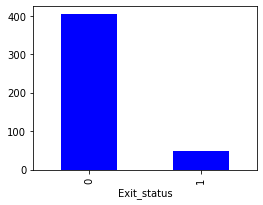

In [16]:
%matplotlib inline
GroupedData=start_ups_14.groupby('Exit_status').size()
GroupedData.plot(kind='bar', figsize=(4,3), cmap='winter')

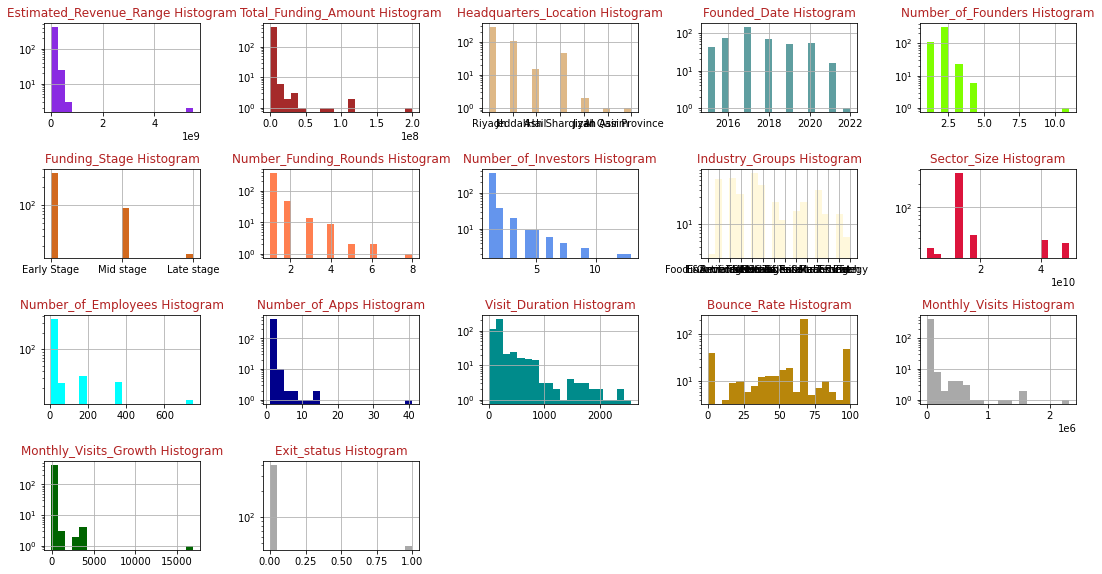

In [17]:
colors = list(mcolors.CSS4_COLORS.keys())[10:]
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(15,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor=colors[i])
        ax.set_title(feature+" Histogram",color=colors[35])
        ax.set_yscale('log')
    fig.tight_layout() 
    plt.savefig('Histograms.png')
    plt.show()
    
draw_histograms(start_ups_14,start_ups_14.columns,10,5)

# <font color = lightgreenblue> 3) Outliers Detection & Treatment 

### <font color =redblue>A. Outlier Detection 

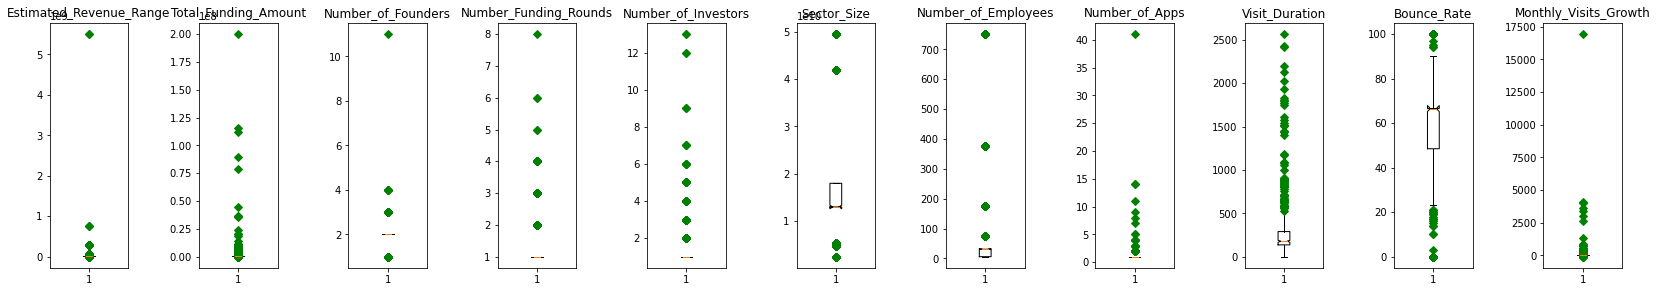

In [18]:
fig, axs = plt.subplots(1, 11)

axs[0].boxplot(start_ups_14['Estimated_Revenue_Range'].apply(lambda x: float(x)), 1, 'gD')
axs[0].set_title('Estimated_Revenue_Range')

axs[1].boxplot(start_ups_14['Total_Funding_Amount'].apply(lambda x: float(x)), 1, 'gD')
axs[1].set_title('Total_Funding_Amount')

axs[2].boxplot(start_ups_14['Number_of_Founders'].apply(lambda x: float(x)), 1, 'gD')
axs[2].set_title('Number_of_Founders')

axs[3].boxplot(start_ups_14['Number_Funding_Rounds'].apply(lambda x: float(x)), 1, 'gD')
axs[3].set_title('Number_Funding_Rounds')

axs[4].boxplot(start_ups_14['Number_of_Investors'].apply(lambda x: float(x)), 1, 'gD')
axs[4].set_title('Number_of_Investors')

axs[5].boxplot(start_ups_14['Sector_Size'].apply(lambda x: float(x)), 1, 'gD')
axs[5].set_title('Sector_Size')

axs[6].boxplot(start_ups_14['Number_of_Employees'].apply(lambda x: float(x)), 1, 'gD')
axs[6].set_title('Number_of_Employees')

axs[7].boxplot(start_ups_14['Number_of_Apps'].apply(lambda x: float(x)), 1, 'gD')
axs[7].set_title('Number_of_Apps') 

axs[8].boxplot(start_ups_14['Visit_Duration'].apply(lambda x: float(x)), 1, 'gD')
axs[8].set_title('Visit_Duration')

axs[9].boxplot(start_ups_14['Bounce_Rate'].apply(lambda x: float(x)), 1, 'gD')
axs[9].set_title('Bounce_Rate')

axs[10].boxplot(start_ups_14['Monthly_Visits_Growth'].apply(lambda x: float(x)), 1, 'gD')
axs[10].set_title('Monthly_Visits_Growth')



fig.subplots_adjust(left=0.06, right=3.70, bottom=0.05, top=0.9,
                    hspace=0.7, wspace=0.9)

In [19]:
start_ups_14['Estimated_Revenue_Range'] = start_ups_14['Estimated_Revenue_Range'].astype('int64')
start_ups_14['Estimated_Revenue_Range_z'] = stats.zscore(start_ups_14['Estimated_Revenue_Range'])

start_ups_14['Total_Funding_Amount'] = start_ups_14['Total_Funding_Amount'].astype('int64')
start_ups_14['Total_Funding_Amount_z'] = stats.zscore(start_ups_14['Total_Funding_Amount'])

start_ups_14['Number_of_Founders'] = start_ups_14['Number_of_Founders'].astype('int64')
start_ups_14['Number_of_Founders_z'] = stats.zscore(start_ups_14['Number_of_Founders'])

start_ups_14['Number_Funding_Rounds'] = start_ups_14['Number_Funding_Rounds'].astype('int64')
start_ups_14['Number_Funding_Rounds_z'] = stats.zscore(start_ups_14['Number_Funding_Rounds'])

start_ups_14['Number_of_Investors'] = start_ups_14['Number_of_Investors'].astype('int64')
start_ups_14['Number_of_Investors_z'] = stats.zscore(start_ups_14['Number_of_Investors'])

start_ups_14['Sector_Size'] = start_ups_14['Sector_Size'].astype('int64')
start_ups_14['Sector_Size_z'] = stats.zscore(start_ups_14['Sector_Size'])

start_ups_14['Number_of_Employees'] = start_ups_14['Number_of_Employees'].astype('int64')
start_ups_14['Number_of_Employees_z'] = stats.zscore(start_ups_14['Number_of_Employees'])

start_ups_14['Number_of_Apps'] = start_ups_14['Number_of_Apps'].astype('int64')
start_ups_14['Number_of_Apps_z'] = stats.zscore(start_ups_14['Number_of_Apps'])

start_ups_14['Visit_Duration'] = start_ups_14['Visit_Duration'].astype('int64')
start_ups_14['Visit_Duration_z'] = stats.zscore(start_ups_14['Visit_Duration'])

start_ups_14['Monthly_Visits'] = start_ups_14['Monthly_Visits'].astype('int64')
start_ups_14['Monthly_Visits_z'] = stats.zscore(start_ups_14['Monthly_Visits'])

start_ups_14['Bounce_Rate'] = start_ups_14['Bounce_Rate'].astype('int64')
start_ups_14['Bounce_Rate_z'] = stats.zscore(start_ups_14['Bounce_Rate'])

start_ups_14['Monthly_Visits_Growth'] = start_ups_14['Monthly_Visits_Growth'].astype('int64')
start_ups_14['Monthly_Visits_Growth_z'] = stats.zscore(start_ups_14['Monthly_Visits_Growth'])

### <font color =redblue> B. Outliers Treatment

In [20]:
def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            outliers = stats.zscore(df[col])
            df[col][outliers < -3] = statistics.median(df[col])
            df[col][outliers >  3] = statistics.median(df[col])
        else:
            df[col]=df[col]
    return df

start_ups_14=cap_data(start_ups_14)

capping the  Estimated_Revenue_Range
capping the  Total_Funding_Amount
capping the  Headquarters_Location
capping the  Founded_Date
capping the  Number_of_Founders
capping the  Funding_Stage
capping the  Number_Funding_Rounds
capping the  Number_of_Investors
capping the  Industry_Groups
capping the  Sector_Size
capping the  Number_of_Employees
capping the  Number_of_Apps
capping the  Visit_Duration
capping the  Bounce_Rate
capping the  Monthly_Visits
capping the  Monthly_Visits_Growth
capping the  Exit_status
capping the  Estimated_Revenue_Range_z
capping the  Total_Funding_Amount_z
capping the  Number_of_Founders_z
capping the  Number_Funding_Rounds_z
capping the  Number_of_Investors_z
capping the  Sector_Size_z
capping the  Number_of_Employees_z
capping the  Number_of_Apps_z
capping the  Visit_Duration_z
capping the  Monthly_Visits_z
capping the  Bounce_Rate_z
capping the  Monthly_Visits_Growth_z


start_ups_14['Estimated_Revenue_Range'][(start_ups_14['Estimated_Revenue_Range_z'] >3) | (start_ups_14['Estimated_Revenue_Range_z'] <-3)] = statistics.median(start_ups_14['Estimated_Revenue_Range']) 

start_ups_14['Total_Funding_Amount'][(start_ups_14['Total_Funding_Amount_z'] >3) | (start_ups_14['Total_Funding_Amount_z'] <-3)] = statistics.median(start_ups_14['Total_Funding_Amount'])

start_ups_14['Number_of_Founders'][(start_ups_14['Number_of_Founders_z'] >3) | (start_ups_14['Number_of_Founders_z'] <-3)] = statistics.median(start_ups_14['Number_of_Founders'])

start_ups_14['Number_Funding_Rounds'][(start_ups_14['Number_Funding_Rounds_z'] >3) | (start_ups_14['Number_Funding_Rounds_z'] <-3)] = statistics.median(start_ups_14['Number_Funding_Rounds'])

start_ups_14['Number_of_Investors'][(start_ups_14['Number_of_Investors_z'] >3) | (start_ups_14['Number_of_Investors_z'] <-3)] = statistics.median(start_ups_14['Number_of_Investors'])

start_ups_14['Sector_Size'][(start_ups_14['Sector_Size_z'] >3) | (start_ups_14['Sector_Size_z'] <-3)] = statistics.median(start_ups_14['Sector_Size'])

start_ups_14['Number_of_Employees'][(start_ups_14['Number_of_Employees_z'] >3) | (start_ups_14['Number_of_Employees_z'] <-3)] = statistics.median(start_ups_14['Number_of_Employees'])

start_ups_14['Number_of_Apps'][(start_ups_14['Number_of_Apps_z'] >3) | (start_ups_14['Number_of_Apps_z'] <-3)] = statistics.median(start_ups_14['Number_of_Apps'])

start_ups_14['Visit_Duration'][(start_ups_14['Visit_Duration_z'] >3) | (start_ups_14['Visit_Duration_z'] <-3)] = statistics.median(start_ups_14['Visit_Duration'])

start_ups_14['Monthly_Visits'][(start_ups_14['Monthly_Visits_z'] >3) | (start_ups_14['Monthly_Visits_z'] <-3)] = statistics.median(start_ups_14['Monthly_Visits'])

start_ups_14['Bounce_Rate'][(start_ups_14['Bounce_Rate_z'] >3) | (start_ups_14['Bounce_Rate_z'] <-3)] = statistics.median(start_ups_14['Bounce_Rate'])

start_ups_14['Monthly_Visits_Growth'][(start_ups_14['Monthly_Visits_Growth_z'] >3) | (start_ups_14['Monthly_Visits_Growth_z'] <-3)] = statistics.median(start_ups_14['Monthly_Visits_Growth'])

fig, axs = plt.subplots(1, 11)

axs[0].boxplot(start_ups_14['Estimated_Revenue_Range'].apply(lambda x: float(x)), 1, 'gD')
axs[0].set_title('Estimated_Revenue_Range')

axs[1].boxplot(start_ups_14['Total_Funding_Amount'].apply(lambda x: float(x)), 1, 'gD')
axs[1].set_title('Total_Funding_Amount')

axs[2].boxplot(start_ups_14['Number_of_Founders'].apply(lambda x: float(x)), 1, 'gD')
axs[2].set_title('Number_of_Founders')

axs[3].boxplot(start_ups_14['Number_Funding_Rounds'].apply(lambda x: float(x)), 1, 'gD')
axs[3].set_title('Number_Funding_Rounds')

axs[4].boxplot(start_ups_14['Number_of_Investors'].apply(lambda x: float(x)), 1, 'gD')
axs[4].set_title('Number_of_Investors')

axs[5].boxplot(start_ups_14['Sector_Size'].apply(lambda x: float(x)), 1, 'gD')
axs[5].set_title('Sector_Size')

axs[6].boxplot(start_ups_14['Number_of_Employees'].apply(lambda x: float(x)), 1, 'gD')
axs[6].set_title('Number_of_Employees')

axs[7].boxplot(start_ups_14['Number_of_Apps'].apply(lambda x: float(x)), 1, 'gD')
axs[7].set_title('Number_of_Apps') 

axs[8].boxplot(start_ups_14['Visit_Duration'].apply(lambda x: float(x)), 1, 'gD')
axs[8].set_title('Visit_Duration')

axs[9].boxplot(start_ups_14['Bounce_Rate'].apply(lambda x: float(x)), 1, 'gD')
axs[9].set_title('Bounce_Rate')

axs[10].boxplot(start_ups_14['Monthly_Visits_Growth'].apply(lambda x: float(x)), 1, 'gD')
axs[10].set_title('Monthly_Visits_Growth')



fig.subplots_adjust(left=0.06, right=3.70, bottom=0.05, top=0.9,
                    hspace=0.7, wspace=0.9)

In [21]:
start_ups_14 = start_ups_14[['Estimated_Revenue_Range', 'Total_Funding_Amount',
       'Headquarters_Location', 'Founded_Date', 'Number_of_Founders',
       'Funding_Stage', 'Number_Funding_Rounds', 'Number_of_Investors',
       'Industry_Groups', 'Sector_Size', 'Number_of_Employees',
       'Number_of_Apps', 'Visit_Duration', 'Bounce_Rate', 'Monthly_Visits',
       'Monthly_Visits_Growth', 'Exit_status']]
start_ups_14.shape

(451, 17)

# <font color = lightgreenblue> 4) Relationship exploration
### <font color =redblue>  A. Test Exit_Status Vs Continuous Variables corrolation using ANOVA test

In [22]:
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [23]:
Continuous = ['Estimated_Revenue_Range', 'Total_Funding_Amount','Founded_Date', 
               'Number_of_Founders','Number_Funding_Rounds', 'Number_of_Investors',
               'Sector_Size', 'Number_of_Employees','Number_of_Apps', 'Visit_Duration', 
               'Bounce_Rate', 'Monthly_Visits','Monthly_Visits_Growth']

In [24]:
# Calling the function to check which categorical variables are correlated with target
FunctionAnova(inpData=start_ups_14, TargetVariable='Exit_status', ContinuousPredictorList= Continuous)

##### ANOVA Results ##### 

Estimated_Revenue_Range is correlated with Exit_status | P-Value: 6.655771574908889e-15
Total_Funding_Amount is NOT correlated with Exit_status | P-Value: 0.18370871979630454
Founded_Date is NOT correlated with Exit_status | P-Value: 0.1625352995304685
Number_of_Founders is correlated with Exit_status | P-Value: 0.044069283441257955
Number_Funding_Rounds is NOT correlated with Exit_status | P-Value: 0.08655398780751543
Number_of_Investors is correlated with Exit_status | P-Value: 0.04433926510739028
Sector_Size is NOT correlated with Exit_status | P-Value: 0.45771984608971206
Number_of_Employees is NOT correlated with Exit_status | P-Value: 0.06059284249439139
Number_of_Apps is NOT correlated with Exit_status | P-Value: 0.4667842442772092
Visit_Duration is NOT correlated with Exit_status | P-Value: 0.7296078889949089
Bounce_Rate is NOT correlated with Exit_status | P-Value: 0.1774014248103408
Monthly_Visits is NOT correlated with Exit_status | P-Value: 0.656

['Estimated_Revenue_Range', 'Number_of_Founders', 'Number_of_Investors']

### <font color =redblue> B. Test Exit_Status Vs Categorical Variables corrolation using Chi-Square Test

In [25]:
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])        
            
    return(SelectedPredictors)

In [26]:
Categorical = ['Headquarters_Location', 'Funding_Stage', 'Industry_Groups']

FunctionChisq(inpData=start_ups_14, TargetVariable='Exit_status', CategoricalVariablesList= Categorical)

Headquarters_Location is correlated with Exit_status | P-Value: 0.020387177874081786
Funding_Stage is NOT correlated with Exit_status | P-Value: 0.6493807534930975
Industry_Groups is NOT correlated with Exit_status | P-Value: 0.6873470907504291


['Headquarters_Location']

# <font color = lightgreenblue>  5) Partitioning the Data

In [27]:
max(start_ups_14['Founded_Date'])

2022

In [28]:
start_ups_14['Industry_Groups'].value_counts()

Artificial Intelligence    81
Financial Services         65
E-Commerce                 63
Travel&Toursim             49
IT                         40
FMCG                       35
HealthTech                 25
Sales&Marketing            25
Media&Entertainment        17
Real Estate                15
EduTech                    15
Human Resources            12
Energy                      6
Food &Beverage              3
Name: Industry_Groups, dtype: int64

In [29]:
start_ups_14 = pd.get_dummies (start_ups_14, columns=['Headquarters_Location', 'Funding_Stage', 'Industry_Groups'])

In [30]:
predictors = ['Estimated_Revenue_Range', 'Total_Funding_Amount', 'Founded_Date',
       'Number_of_Founders', 'Number_Funding_Rounds', 'Number_of_Investors',
       'Sector_Size', 'Number_of_Employees', 
       'Visit_Duration', 'Bounce_Rate', 'Monthly_Visits',
       'Monthly_Visits_Growth', 
       'Headquarters_Location_Al Qasim ',
       'Headquarters_Location_Ash Sharqiyah',
       'Headquarters_Location_Asir Province', 'Headquarters_Location_Hail',
       'Headquarters_Location_Jeddah', 'Headquarters_Location_Jizan',
       'Headquarters_Location_Riyadh', 'Funding_Stage_Early Stage',
       'Funding_Stage_Late stage', 'Funding_Stage_Mid stage',
       'Industry_Groups_Artificial Intelligence', 'Industry_Groups_E-Commerce',
       'Industry_Groups_EduTech', 'Industry_Groups_Energy',
       'Industry_Groups_FMCG', 'Industry_Groups_Financial Services',
       'Industry_Groups_Food &Beverage ', 'Industry_Groups_HealthTech',
       'Industry_Groups_Human Resources', 'Industry_Groups_IT',
       'Industry_Groups_Media&Entertainment', 'Industry_Groups_Real Estate',
       'Industry_Groups_Sales&Marketing', 'Industry_Groups_Travel&Toursim']

outcome = 'Exit_status'

X= start_ups_14[predictors]
y= start_ups_14[outcome]

# Scale the data
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X
X=PredictorScalerFit.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [31]:
y_train.value_counts()

0    238
1     32
Name: Exit_status, dtype: int64

In [32]:
y_test.value_counts()

0    166
1     15
Name: Exit_status, dtype: int64

### <font color =redblue> Oversampling Training set

In [33]:
# Oversample training data
sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

# class distribution
print(Counter(y_train))
# new class distribution 
print(Counter(y_train))

Counter({0: 238, 1: 238})
Counter({0: 238, 1: 238})


In [34]:
X_train

array([[-0.26385466, -0.21809641,  0.28531035, ..., -0.18548226,
        -0.24225079, -0.34912827],
       [-0.26385466, -0.21809641, -1.58859695, ..., -0.18548226,
        -0.24225079, -0.34912827],
       [-0.31440148, -0.30977353, -0.96396118, ..., -0.18548226,
        -0.24225079, -0.34912827],
       ...,
       [ 0.25433501, -0.21809641, -0.93987925, ..., -0.18548226,
        -0.24225079, -0.34912827],
       [ 0.43579803, -0.21809641, -0.33932542, ..., -0.18548226,
        -0.24225079, -0.34912827],
       [-0.16030735, -0.21809641, -1.52993989, ..., -0.18548226,
        -0.24225079, -0.34912827]])

# <font color = lightnavy> 6) Multiple Prediction Models 

In [35]:
# Function to compute the detailed confusion matrix
def model_eval(matrix,model_name):
    tn = matrix.iloc[0,0]
    tp = matrix.iloc[1,1]
    fn = matrix.iloc[1,0]
    fp = matrix.iloc[0,1]
    tap = fn+tp
    tan = tn+fp
    tpn = tn+fn
    tpp = fp+tp
    precision = tp/tpp
    recall = tp/tap
    total = tn+tp+fn+fp

    data = [ 
    round((tp+tn)/total,4), 
    round(1-((tp+tn)/total),4),
    round(tp/tap,4),
    round(tn/tan,4),
    round(precision,4),
    round(2 * (precision * recall) / (precision + recall),4),
    round(5 * (precision * recall) / ((4 * precision) + recall),4), 
    round(1.25 * (precision * recall) / ((.25 * precision) + recall),4)  
 ] 
    return( 
pd.DataFrame(data, columns=[model_name], 
             index=['Accuracy','ErrorRate','Sensitivity','Specificity','Precision','F1','F2','F3']) 
)

In [36]:
# Function to predict using training and validation data
def model_predict(train_X, train_y, valid_X, valid_y, model_name, label):
    train_predict = model_name.predict(train_X)
    train_con_table = pd.crosstab(train_y, train_predict)
    train_Model = model_eval(train_con_table,model_name = label +'_Train') 

    valid_predict = model_name.predict(valid_X)
    valid_con_table = pd.crosstab(valid_y, valid_predict)
    valid_Model = model_eval(valid_con_table,model_name = label +'_Valid') 

    return pd.concat([train_Model, valid_Model], axis=1)

## <font color =redblue> 1. Random Forest
### <font color =redblue> Starting with RF to exploare the Feature Importance 

In [37]:
RF = RandomForestClassifier(max_depth=3, n_estimators=100)
RF.fit(X_train, y_train)
RF_model = model_predict(X_train, y_train, X_test, y_test, RF, 'RF')
RF_model

,RF_Train,RF_Valid
Accuracy,0.9097,0.7514
ErrorRate,0.0903,0.2486
Sensitivity,0.9412,0.6000
Specificity,0.8782,0.7651
Precision,0.8854,0.1875
F1,0.9124,0.2857
F2,0.9295,0.4167
F3,0.8960,0.2174


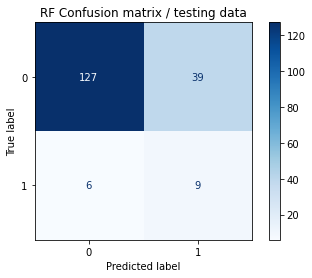

In [38]:
plot_confusion_matrix(RF, X_test, y_test, cmap = 'Blues')
plt.title('RF Confusion matrix / testing data')
plt.show()

In [39]:
X_train_std = pd.DataFrame(X_train, columns=predictors)
RF.fit(X_train_std, y_train)
importances = RF.feature_importances_
df = pd.DataFrame({'feature':pd.DataFrame(X_train_std).columns, 'importance': importances})
df = df.sort_values('importance')
print(df)

                                    feature  importance
17              Headquarters_Location_Jizan    0.000000
14      Headquarters_Location_Asir Province    0.000000
12          Headquarters_Location_Al Qasim     0.000000
30          Industry_Groups_Human Resources    0.000000
28          Industry_Groups_Food &Beverage     0.000000
27       Industry_Groups_Financial Services    0.000209
25                   Industry_Groups_Energy    0.000232
26                     Industry_Groups_FMCG    0.000335
15               Headquarters_Location_Hail    0.000792
32      Industry_Groups_Media&Entertainment    0.002011
33              Industry_Groups_Real Estate    0.002012
29               Industry_Groups_HealthTech    0.002354
31                       Industry_Groups_IT    0.002598
34          Industry_Groups_Sales&Marketing    0.003670
16             Headquarters_Location_Jeddah    0.003798
20                 Funding_Stage_Late stage    0.004430
13      Headquarters_Location_Ash Sharqiyah    0

Text(0.5, 0, 'Random Forest Feature Importance')

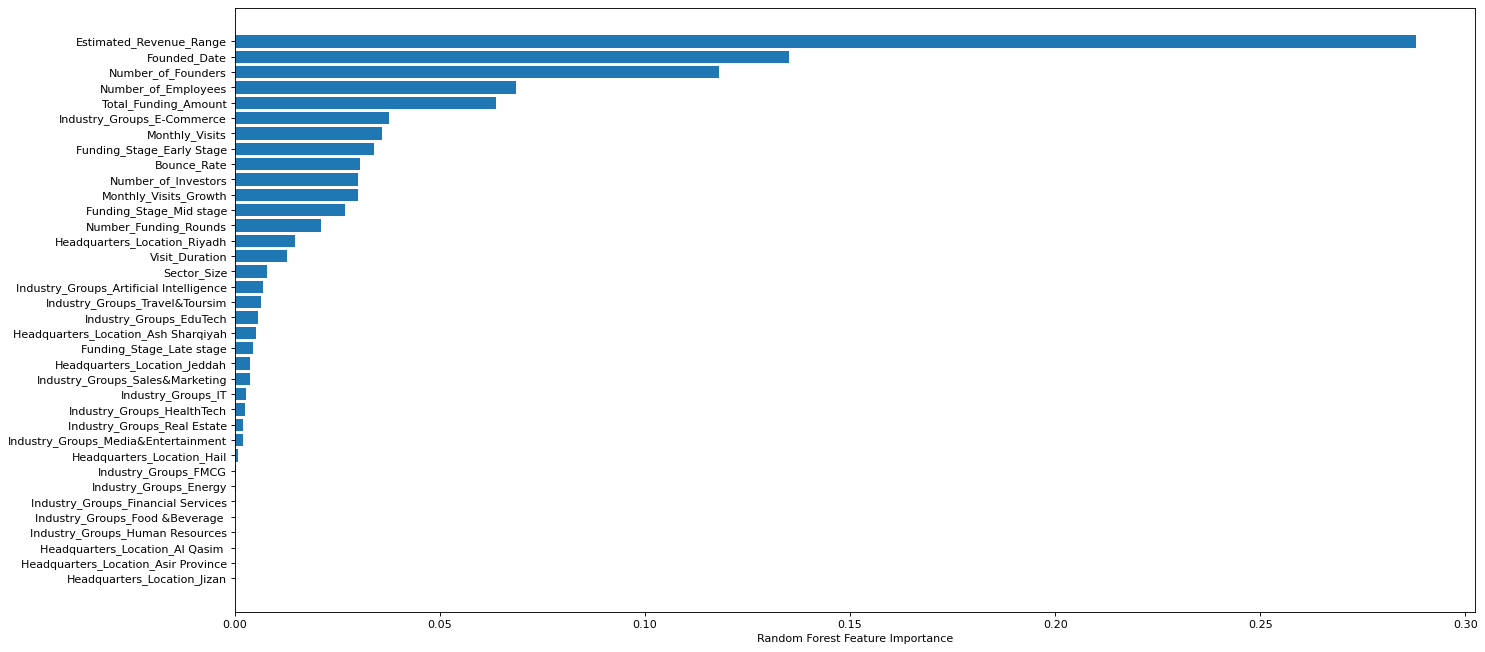

In [40]:
sorted_idx = RF.feature_importances_.argsort()
plt.figure(figsize=(20, 10), dpi=80)
plt.barh(X_train_std.columns[sorted_idx], RF.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## <font color =darkblue> Statistically we conclude that these features are the most important;                                                         
#### <font color =darkblue> Estimated_Revenue_Range , Number_of_Founders , Number_of_Employees , Monthly_Visits , Founded_Date                  
#### <font color =darkblue> However, based on domain knowledge we decided to keep the other features that was included during the partition step 

## <font color =redblue> 2. Naive Bayes

In [41]:
NB = GaussianNB()
NB.fit(X_train, y_train)
NB_model = model_predict(X_train, y_train, X_test, y_test, NB, 'NB')
NB_model

,NB_Train,NB_Valid
Accuracy,0.6744,0.3425
ErrorRate,0.3256,0.6575
Sensitivity,0.9916,0.6000
Specificity,0.3571,0.3193
Precision,0.6067,0.0738
F1,0.7528,0.1314
F2,0.8799,0.2473
F3,0.6577,0.0895


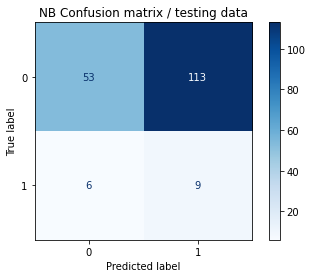

In [42]:
plot_confusion_matrix(NB, X_test, y_test, cmap= 'Blues')
plt.title('NB Confusion matrix / testing data')
plt.show()

## <font color =redblue> 3. Logistic Regression 

In [43]:
LR = LogisticRegression(C=1,penalty='l2', solver='newton-cg')
LR.fit(X_train, y_train)
LR_model = model_predict(X_train, y_train, X_test, y_test, LR, 'LR')
LR_model

,LR_Train,LR_Valid
Accuracy,0.8067,0.7238
ErrorRate,0.1933,0.2762
Sensitivity,0.8487,0.4667
Specificity,0.7647,0.7470
Precision,0.7829,0.1429
F1,0.8145,0.2187
F2,0.8347,0.3211
F3,0.7953,0.1659


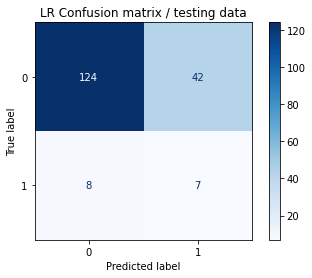

In [44]:
plot_confusion_matrix(LR, X_test, y_test, cmap='Blues')
plt.title('LR Confusion matrix / testing data')
plt.show()

## <font color =redblue> 4. K-Nearest Neighbor (KNN) 

In [45]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train, y_train)
KNN_model = model_predict(X_train, y_train, X_test, y_test, KNN, 'KNN')
KNN_model

,KNN_Train,KNN_Valid
Accuracy,0.9559,0.7956
ErrorRate,0.0441,0.2044
Sensitivity,1.0000,0.2667
Specificity,0.9118,0.8434
Precision,0.9189,0.1333
F1,0.9577,0.1778
F2,0.9827,0.2222
F3,0.9341,0.1481


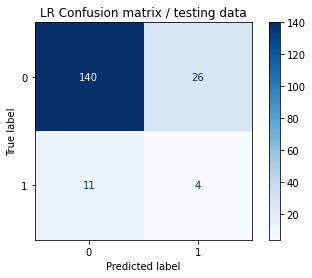

In [46]:
plot_confusion_matrix(KNN, X_test, y_test, cmap='Blues')
plt.title('LR Confusion matrix / testing data')
plt.show()

## <font color =redblue> 5. SVM

In [47]:
SVM = svm.SVC(kernel='linear', probability=True)
SVM.fit(X_train, y_train)
SVM_model = model_predict(X_train, y_train, X_test, y_test, SVM, 'SVM')
SVM_model

,SVM_Train,SVM_Valid
Accuracy,0.8151,0.6796
ErrorRate,0.1849,0.3204
Sensitivity,0.8824,0.6667
Specificity,0.7479,0.6807
Precision,0.7778,0.1587
F1,0.8268,0.2564
F2,0.8592,0.4065
F3,0.7967,0.1873


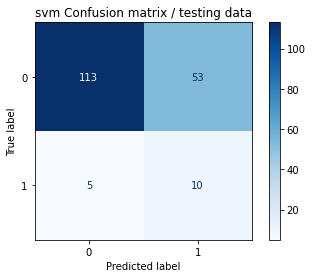

In [48]:
plot_confusion_matrix(SVM, X_test, y_test, cmap='Blues')
plt.title('svm Confusion matrix / testing data')
plt.show()

## <font color =redblue> 6. Decision Trees 

In [49]:
DT = tree.DecisionTreeClassifier(max_depth=4,criterion='gini')
DT.fit(X_train, y_train)
DT_model = model_predict(X_train, y_train, X_test, y_test, DT, 'DT')
DT_model

,DT_Train,DT_Valid
Accuracy,0.9118,0.8729
ErrorRate,0.0882,0.1271
Sensitivity,0.8613,0.5333
Specificity,0.9622,0.9036
Precision,0.9579,0.3333
F1,0.9071,0.4103
F2,0.8791,0.4762
F3,0.9369,0.3604


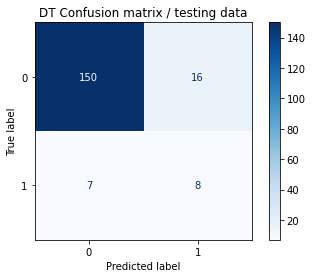

In [50]:
plot_confusion_matrix(DT, X_test, y_test, cmap='Blues')
plt.title('DT Confusion matrix / testing data')
plt.show()

## <font color =redblue> 7. XGBoost

In [51]:
XGB = XGBClassifier(max_depth=2, learning_rate=0.01, n_estimators=200, objective='binary:logistic', booster='gbtree')
XGB.fit(X_train, y_train)
XGB_model = model_predict(X_train, y_train, X_test, y_test, XGB, 'XGB')
XGB_model

,XGB_Train,XGB_Valid
Accuracy,0.9013,0.8619
ErrorRate,0.0987,0.1381
Sensitivity,0.8697,0.5333
Specificity,0.9328,0.8916
Precision,0.9283,0.3077
F1,0.8980,0.3902
F2,0.8809,0.4651
F3,0.9159,0.3361


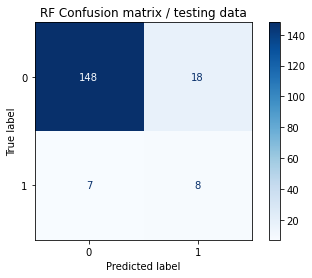

In [52]:
plot_confusion_matrix(XGB, X_test, y_test, cmap = 'Blues')
plt.title('RF Confusion matrix / testing data')
plt.show()

## <font color =redblue> 8. Neural Network

In [53]:
NN = MLPClassifier(hidden_layer_sizes=(1), activation='logistic', solver='lbfgs', random_state=1)
NN.fit(X_train, y_train)
NN_model = model_predict(X_train, y_train, X_test, y_test, NN, 'NN')
NN_model

,NN_Train,NN_Valid
Accuracy,0.8950,0.6685
ErrorRate,0.1050,0.3315
Sensitivity,1.0000,0.5333
Specificity,0.7899,0.6807
Precision,0.8264,0.1311
F1,0.9049,0.2105
F2,0.9597,0.3306
F3,0.8561,0.1544


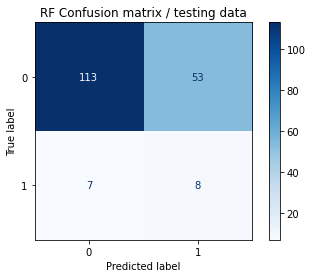

In [54]:
plot_confusion_matrix(NN, X_test, y_test, cmap = 'Blues')
plt.title('RF Confusion matrix / testing data')
plt.show()

## <font color =redblue> 9. Linear Discriminant Analysis (LDA)

In [55]:
LDA = LDA()
LDA.fit(X_train, y_train)
LDA_model = model_predict(X_train, y_train, X_test, y_test, LDA, 'LDA')
LDA_model

,LDA_Train,LDA_Valid
Accuracy,0.8088,0.7017
ErrorRate,0.1912,0.2983
Sensitivity,0.8361,0.4667
Specificity,0.7815,0.7229
Precision,0.7928,0.1321
F1,0.8139,0.2059
F2,0.8271,0.3097
F3,0.8011,0.1542


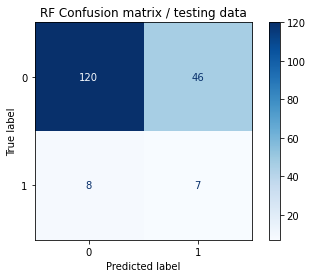

In [56]:
plot_confusion_matrix(LDA, X_test, y_test, cmap = 'Blues')
plt.title('RF Confusion matrix / testing data')
plt.show()

# <font color = lightgreenblue> 7) Models Evaluation

In [57]:
pd.concat([RF_model, NB_model, LR_model, KNN_model, SVM_model, DT_model,  XGB_model, NN_model, LDA_model], axis=1)

,RF_Train,RF_Valid,NB_Train,NB_Valid,LR_Train,LR_Valid,KNN_Train,KNN_Valid,SVM_Train,SVM_Valid,DT_Train,DT_Valid,XGB_Train,XGB_Valid,NN_Train,NN_Valid,LDA_Train,LDA_Valid
Accuracy,0.9097,0.7514,0.6744,0.3425,0.8067,0.7238,0.9559,0.7956,0.8151,0.6796,0.9118,0.8729,0.9013,0.8619,0.8950,0.6685,0.8088,0.7017
ErrorRate,0.0903,0.2486,0.3256,0.6575,0.1933,0.2762,0.0441,0.2044,0.1849,0.3204,0.0882,0.1271,0.0987,0.1381,0.1050,0.3315,0.1912,0.2983
Sensitivity,0.9412,0.6000,0.9916,0.6000,0.8487,0.4667,1.0000,0.2667,0.8824,0.6667,0.8613,0.5333,0.8697,0.5333,1.0000,0.5333,0.8361,0.4667
Specificity,0.8782,0.7651,0.3571,0.3193,0.7647,0.7470,0.9118,0.8434,0.7479,0.6807,0.9622,0.9036,0.9328,0.8916,0.7899,0.6807,0.7815,0.7229
Precision,0.8854,0.1875,0.6067,0.0738,0.7829,0.1429,0.9189,0.1333,0.7778,0.1587,0.9579,0.3333,0.9283,0.3077,0.8264,0.1311,0.7928,0.1321
F1,0.9124,0.2857,0.7528,0.1314,0.8145,0.2187,0.9577,0.1778,0.8268,0.2564,0.9071,0.4103,0.8980,0.3902,0.9049,0.2105,0.8139,0.2059
F2,0.9295,0.4167,0.8799,0.2473,0.8347,0.3211,0.9827,0.2222,0.8592,0.4065,0.8791,0.4762,0.8809,0.4651,0.9597,0.3306,0.8271,0.3097
F3,0.8960,0.2174,0.6577,0.0895,0.7953,0.1659,0.9341,0.1481,0.7967,0.1873,0.9369,0.3604,0.9159,0.3361,0.8561,0.1544,0.8011,0.1542


### NN & LDA almost the sam accuracy and sensitivity ,,, DT & XGB amlost the same accuracy and sensitivity ,,, Based on statistical measures, SVM is the best model since it has the highest sensitivity with resonable overall accuracy 70 %

### <font color =redblue> ROC Curve to show the trade-off between sensitivity and specificity

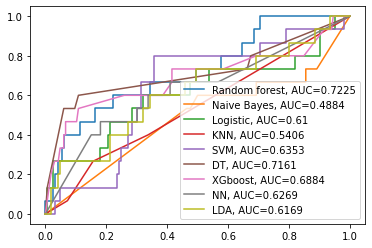

In [58]:
plt.figure(0).clf()

y_pred = RF.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random forest, AUC="+str(auc))

y_pred = NB.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

y_pred = LR.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))

y_pred = KNN.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

y_pred = SVM.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))

y_pred = DT.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="DT, AUC="+str(auc))


y_pred = XGB.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGboost, AUC="+str(auc))

y_pred = NN.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="NN, AUC="+str(auc))

y_pred = LDA.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="LDA, AUC="+str(auc))

plt.legend()